# setup

In [1]:
# !pip install easyimages.

# # install dependencies: (use cu101 because colab has CUDA 10.1)
# !pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
# !pip install cython pyyaml==5.1
# !pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
# import torch, torchvision
# print(torch.__version__, torch.cuda.is_available())
# !gcc --version
# !python -m pip install pyyaml==5.1
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

# !pip install segmentation_models_pytorch
# !pip install roboflow
# !pip install pycocotools


Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
^C
ERROR: Operation cancelled by user
  Using cached Cython-3.0.9-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)
  Using cached PyYAML-5.1.tar.gz (274 kB)
  Preparing metadata (setup.py) ... done
Using legacy 'setup.py install' for pyyaml, since package 'wheel' is not installed.
  Running setup.py install for pyyaml ... done


# Lib

In [52]:
import pandas as pd
import numpy as np
import json
import os
import seaborn as sns
from matplotlib.patches import Rectangle
import json
import pandas as pd
import matplotlib.pyplot as plt
# from skimage.io import imread
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from PIL import Image, ImageDraw


import cv2

# from fastai.vision import *
from IPython.core.display import HTML
# HTML("<style>div.output_area pre {white-space: pre;}</style>")
import ipywidgets as widgets
from IPython.display import display

from utils.functions import *
from utils.functions_satellite_image import *

# %matplotlib inline
from sys import path


path.append(os.path.join(os.getcwd(), '')) 
os.chdir(os.path.join(os.getcwd(), ''))

from IPython.display import  display
import glob


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)


In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
# import some common libraries
import numpy as np
import cv2
import random
# from google.colab.patches import cv2_imshow
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog
from detectron2.engine import DefaultTrainer, default_argument_parser, default_setup, launch
from detectron2.checkpoint import DetectionCheckpointer

import glob
import random
from detectron2.utils.visualizer import Visualizer


import os
from pycocotools.coco import COCO
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
# %matplotlib inline

# Functions

In [7]:
def rename_all_file_in_a_directory(folder):
  import os
  # Iterate
  i = 1 
  for file in os.listdir(folder):
    # Checking if the file is present in the list
    # if file in filesRename:
    oldName = os.path.join(folder, file)
    n = os.path.splitext(file)[0]

    b = str(i) + '_new' + '.jpg'
    newName = os.path.join(folder, b)
    i = i+1
    # Rename the file
    os.rename(oldName, newName)

  res = os.listdir(folder)
  # print(res)

# Read data

In [64]:
dir_read = "data/roof_panel_seg_v6i_coco_segmentation"

In [5]:
json_path = os.path.join(dir_read + '/train', '_annotations.coco.json')
with open(json_path, 'r') as f:
    annot_data_train = json.load(f)

json_path = os.path.join(dir_read + '/valid', '_annotations.coco.json')
with open(json_path, 'r') as f:
    annot_data_valid = json.load(f)

json_path = os.path.join(dir_read + '/test', '_annotations.coco.json')
with open(json_path, 'r') as f:
    annot_data_test = json.load(f)

In [6]:
annot_data_train.keys()

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])

In [7]:
annot_data_train["info"]

{'year': '2023',
 'version': '6',
 'description': 'Exported from roboflow.ai',
 'contributor': '',
 'url': 'https://public.roboflow.ai/object-detection/undefined',
 'date_created': '2023-05-30T07:38:01+00:00'}

In [8]:
annot_data_train['licenses']

[{'id': 1,
  'url': 'https://creativecommons.org/licenses/by/4.0/',
  'name': 'CC BY 4.0'}]

In [9]:
annot_data_train["categories"]

[{'id': 0, 'name': 'roof-panel', 'supercategory': 'none'},
 {'id': 1, 'name': 'background', 'supercategory': 'roof-panel'},
 {'id': 2, 'name': 'panel', 'supercategory': 'roof-panel'},
 {'id': 3, 'name': 'roof', 'supercategory': 'roof-panel'}]

In [10]:
annot_data_train["images"][2]["file_name"]

'roof_21_jpeg_jpg.rf.014d37b4444a6adca32d53433d26c94e.jpg'

In [11]:
df_train = pd.DataFrame(annot_data_train['annotations'])
df_valid = pd.DataFrame(annot_data_valid['annotations'])
df_test = pd.DataFrame(annot_data_test['annotations'])

print("df_train shape:", df_train.shape)
print("df_valid shape:", df_valid.shape)
print("df_test shape:", df_test.shape)

df_train["category_name"] = df_train["category_id"].apply(lambda x : replace_name_of_categori(x))
df_valid["category_name"] = df_train["category_id"].apply(lambda x : replace_name_of_categori(x))
df_test["category_name"] = df_train["category_id"].apply(lambda x : replace_name_of_categori(x))

df_train["image_name"] = None
df_train["height"] = None
df_train["width"] = None


df_valid["image_name"] = None
df_valid["height"] = None
df_valid["width"] = None


df_test["image_name"] = None
df_test["height"] = None
df_test["width"] = None

for i in range(0,len(annot_data_train["images"])):
  img_id = annot_data_train["images"][i]["id"]
  image_name = annot_data_train["images"][i]["file_name"]
  h = annot_data_train["images"][i]["height"]
  w = annot_data_train["images"][i]["width"]
  x = df_train[df_train["image_id"] == img_id].index
  df_train.iloc[x,df_train.columns.get_loc("image_name")] = image_name
  df_train.iloc[x,df_train.columns.get_loc("height")] = h
  df_train.iloc[x,df_train.columns.get_loc("width")] = w



for i in range(0,len(annot_data_valid["images"])):
  img_id = annot_data_valid["images"][i]["id"]
  image_name = annot_data_valid["images"][i]["file_name"]
  h = annot_data_valid["images"][i]["height"]
  w = annot_data_valid["images"][i]["width"]
  x = df_valid[df_valid["image_id"] == img_id].index
  df_valid.iloc[x,df_valid.columns.get_loc("image_name")] = image_name
  df_valid.iloc[x,df_valid.columns.get_loc("height")] = h
  df_valid.iloc[x,df_valid.columns.get_loc("width")] = w


for i in range(0,len(annot_data_test["images"])):
  img_id = annot_data_test["images"][i]["id"]
  image_name = annot_data_test["images"][i]["file_name"]
  h = annot_data_test["images"][i]["height"]
  w = annot_data_test["images"][i]["width"]
  x = df_test[df_test["image_id"] == img_id].index
  df_test.iloc[x,df_test.columns.get_loc("image_name")] = image_name
  df_test.iloc[x,df_test.columns.get_loc("height")] = h
  df_test.iloc[x,df_test.columns.get_loc("width")] = w



df_train.sample(10)

df_train shape: (4608, 7)
df_valid shape: (1161, 7)
df_test shape: (706, 7)


,id,image_id,category_id,bbox,area,segmentation,iscrowd,category_name,image_name,height,width
4378,4378,592,2,"[169, 162, 30.15, 15.565]",469.286,"[[168.565, 161.602, 168.908, 173.047, 198.715,...",0,roof,Screenshot-from-2023-05-18-21-57-23_png_jpg.rf...,640,640
94,94,20,2,"[77, 286, 19.185, 30.672]",588.439,"[[92.086, 306.266, 94.772, 299.857, 95.348, 28...",0,roof,Screenshot-from-2023-05-18-21-58-06_png_jpg.rf...,640,640
3624,3624,476,3,"[108, 367, 112.941, 272.868]",30818.057,"[[215.843, 458.915, 220.863, 434.109, 220.863,...",0,None,Screenshot-from-2023-05-18-22-42-28_png_jpg.rf...,640,640
1648,1648,218,3,"[175, 52, 48.64, 87.68]",4264.755,"[[224, 56.96, 215.68, 52.48, 178.56, 53.76, 17...",0,None,map_38-707387010912264_-90-16306676219229_38-7...,640,640
3290,3290,435,3,"[509, 470, 81.343, 118.112]",9607.542,"[[590.12, 551.645, 589.928, 544.778, 518.945, ...",0,None,Screenshot-from-2023-05-18-21-58-06_png_jpg.rf...,640,640
2776,2776,365,2,"[321, 321, 38.373, 48.984]",1879.653,"[[329.251, 321.373, 321.37, 351.13, 340.214, 3...",0,roof,Screenshot-from-2023-05-18-21-57-06_png_jpg.rf...,640,640
3663,3663,482,3,"[303, 24, 192, 171.52]",32931.840,"[[366.72, 192, 379.52, 190.72, 381.44, 168.32,...",0,None,map_39-26435144703396_-103-67724421636495_39-2...,640,640
542,542,75,3,"[293, 186, 125.44, 108.16]",13567.590,"[[389.76, 290.56, 413.44, 261.76, 418.56, 246....",0,None,map_60-389242609752344_5-316315437073595_60-38...,640,640
413,413,64,3,"[298, 52, 163.84, 247.68]",40579.891,"[[405.76, 214.4, 462.08, 208, 462.08, 155.52, ...",0,None,map_38-70807016406832_-90-15593753034081_38-70...,640,640
1167,1167,142,3,"[0, 2, 598.418, 626.581]",374957.186,"[[0, 372.645, 109.379, 417.032, 129.266, 427.3...",0,None,Screenshot-from-2023-05-18-22-33-00_png_jpg.rf...,640,640


In [12]:
df_train["category_id"].unique().tolist()

[2, 3, 1]

In [13]:
df_train[df_train["category_id"]== 1].head(2)

,id,image_id,category_id,bbox,area,segmentation,iscrowd,category_name,image_name,height,width
2552,2552,323,1,"[0, 0, 640, 640]",409600.000,"[[0, 0, 0, 640, 640, 640, 640, 0, 0, 0]]",0,panel,map_39-26435144703396_-103-67724421636495_39-2...,640,640
2888,2888,377,1,"[0, 1, 640, 636.339]",407257.088,"[[640, 0.922, 0, 0.922, 0, 637.261, 640, 637.2...",0,panel,map_60-39029089977786_5-320497481755511_60-390...,640,640


In [55]:
df_train.groupby("image_id").count().head(2)

,id,category_id,bbox,area,segmentation,iscrowd,category_name,image_name,height,width
image_id,,,,,,,,,,
0,6,6,6,6,6,6,6,6,6,6
1,1,1,1,1,1,1,1,1,1,1


In [56]:
df_train[df_train["image_id"]== 0]

,id,image_id,category_id,bbox,area,segmentation,iscrowd,category_name,image_name,height,width
0,0,0,2,"[218, 138, 269.361, 214.948]",57898.735,"[[242.107, 137.634, 218.023, 312.65, 466.469, 352.583, 487.384, 174.167, 249.08, 139.334, 242.107, 137.634]]",0,roof,Screenshot-from-2023-05-18-22-17-10_png_jpg.rf.00c0c1308cc3c53d43959b824a415200.jpg,640,640
1,1,0,2,"[484, 217, 98.237, 119.795]",11768.221,"[[483.582, 318.598, 575.48, 336.44, 581.818, 242.984, 581.818, 242.136, 493.722, 216.646, 483.582, 318.598]]",0,roof,Screenshot-from-2023-05-18-22-17-10_png_jpg.rf.00c0c1308cc3c53d43959b824a415200.jpg,640,640
2,2,0,2,"[388, 349, 150.207, 196.257]",29479.177,"[[401.822, 349.183, 387.879, 519.102, 525.411, 545.441, 538.086, 371.273, 406.258, 351.732, 401.822, 349.183]]",0,roof,Screenshot-from-2023-05-18-22-17-10_png_jpg.rf.00c0c1308cc3c53d43959b824a415200.jpg,640,640
3,3,0,2,"[106, 345, 208.517, 209]",43580.039,"[[121.054, 344.935, 105.843, 519.102, 296.613, 553.935, 314.36, 376.37, 121.054, 344.935]]",0,roof,Screenshot-from-2023-05-18-22-17-10_png_jpg.rf.00c0c1308cc3c53d43959b824a415200.jpg,640,640
4,4,0,2,"[101, 304, 450.625, 257.427]",116002.963,"[[159.714, 304.156, 117.885, 314.35, 101.406, 502.96, 304.852, 561.583, 311.191, 519.102, 528.58, 558.183, 552.031, 372.122, 159.714, 305.005, 159.714, 304.156]]",0,roof,Screenshot-from-2023-05-18-22-17-10_png_jpg.rf.00c0c1308cc3c53d43959b824a415200.jpg,640,640
5,5,0,2,"[103, 123, 485.483, 463.878]",225204.987,"[[206.616, 268.472, 112.815, 300.756, 102.674, 525.899, 527.312, 587.07, 576.748, 380.619, 588.157, 173.318, 569.776, 158.025, 219.926, 123.192, 206.616, 268.472]]",0,roof,Screenshot-from-2023-05-18-22-17-10_png_jpg.rf.00c0c1308cc3c53d43959b824a415200.jpg,640,640


# Plot image with box and polygons of each segmentation

In [14]:
# dir_read =  "data/roof_panel_seg_v6i_coco_segmentation"

train_images =  glob.glob(dir_read + "/train/*jpg")
valid_images =  glob.glob(dir_read + "/valid/*jpg")
test_images =  glob.glob(dir_read + "/test/*jpg")

print("no_train_image", len(train_images))
print("no_masked_train" , df_train.groupby("image_id").count()["id"].shape[0])
print("no_valid",len(valid_images))
print("no_masked_valid" , df_valid.groupby("image_id").count()["id"].shape[0])
print("no_test", len(test_images))
print( "no_masked_test" , df_test.groupby("image_id").count()["id"].shape[0])

no_train_image 1225
no_masked_train 602
no_valid 349
no_masked_valid 171
no_test 182
no_masked_test 90


In [93]:
def creat_mask(data, name, dir_, dir_read, new_folder_name_mask, new_folder_name_main ):
  """creating mask for panel in blue and for roof in red"""

  # new_folder_name_mask= f"{name}_mask"
  # new_folder_name_main = f'{name}_new'

  # if os.path.isdir(new_folder_name_mask):
  #     pass
  # else:
  #     os.mkdir(new_folder_name_mask)

  # if os.path.isdir(new_folder_name_main):
  #     pass
  # else:
  #     os.mkdir(new_folder_name_main)


  image_id_list = data["image_id"].unique().tolist()
  for k in image_id_list:
    # print(k)

    df = data[data["image_id"] == k]
    df.sort_values("area", inplace = True, ascending = False)

    file_name = df.iloc[0]["image_name"]
    # print(file_name)

    image = Image.open(dir_ + file_name)
    image_1 = image.copy()
    im = cv2.imread(dir_ + file_name)
    h, w, c = im.shape


    draw = ImageDraw.Draw(image)
    rectangle = [(0, 0), (w, h)]
    draw.rectangle(rectangle , outline="black", fill = "black")

    for i, row in df.iterrows():
        bbox = row['bbox']  

        segmentation = row["segmentation"][0]
        if row["category_id"] == 1:  #panel #none
          color_of_category = 'blue'

        if row["category_id"] == 2:  #roof  #pannel
          color_of_category = "red"
        
        if row["category_id"] == 3:  #none  # roof
          color_of_category = "white"

        pair_of_tuples = [(segmentation[i], segmentation[i+1]) for i in range(0, len(segmentation), 2)]
        draw.polygon(pair_of_tuples, outline='red', fill = color_of_category )

    # name_2 = file_name + f"{name}_mask"


    image.save(dir_read + f'/{new_folder_name_mask}/{name}_{k}.jpg')
    image_1.save(dir_read + f'/{new_folder_name_main}/{name}_{k}.jpg')





In [ ]:
data = df_train
name = "train"
dir_ = dir_read  + "/train/"
new_folder_name_mask = "train_mask"
new_folder_name_main = "train_new"
print(dir_)
creat_mask(data, name, dir_, dir_read, new_folder_name_mask, new_folder_name_main )

data =df_valid
name = "valid"
dir_ = dir_read + "/valid/"
new_folder_name_mask = "valid_mask"
new_folder_name_main = "valid_new"
creat_mask(data, name, dir_, dir_read, new_folder_name_mask, new_folder_name_main )

data =df_test
name = "test"
dir_ = dir_read + "/test/"
new_folder_name_mask = "test_mask"
new_folder_name_main = "test_new"
creat_mask(data,name,dir_, dir_read, new_folder_name_mask, new_folder_name_main )

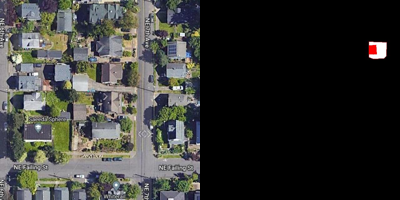

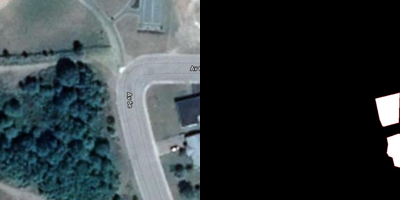

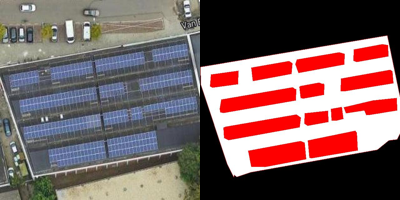

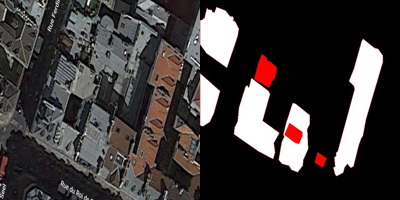

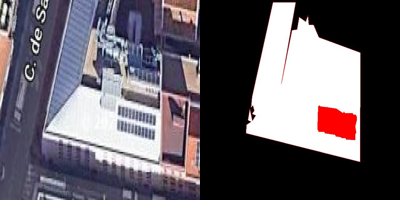

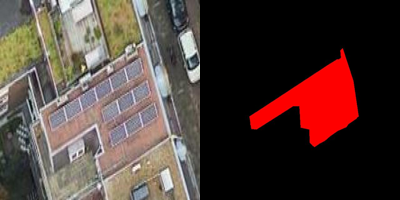

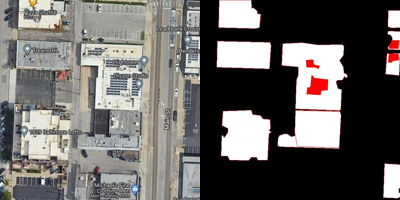

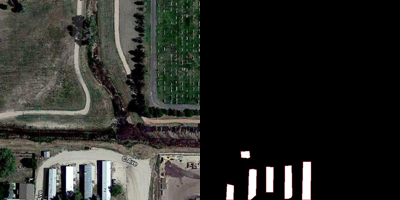

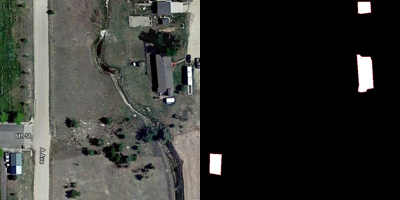

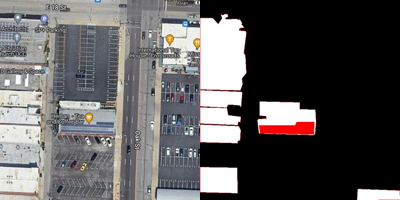

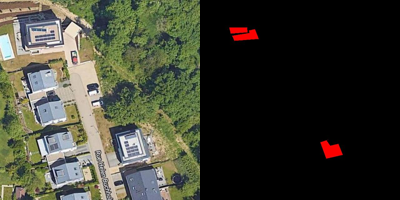

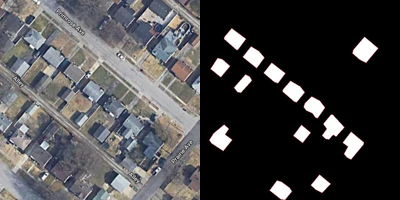

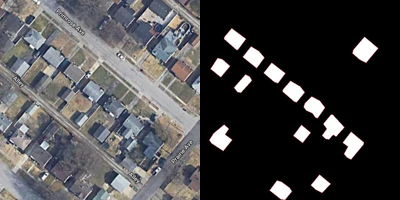

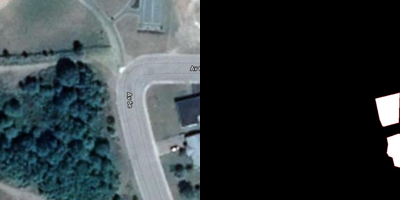

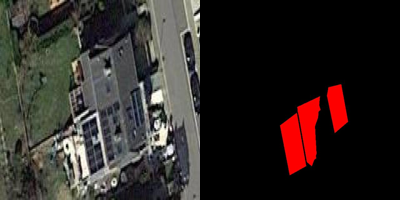

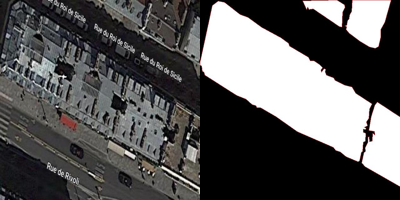

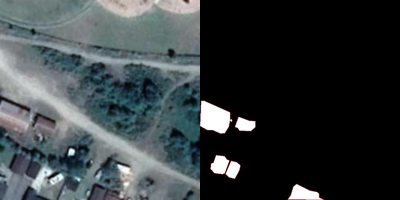

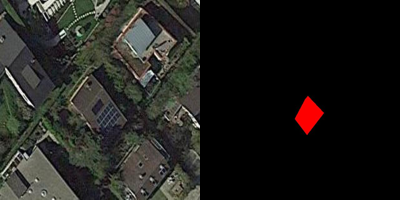

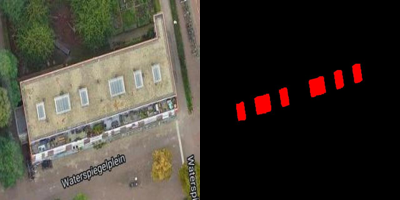

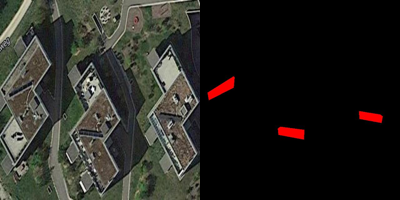

In [69]:
import random

n = 20  # Number of random integers to select
start = 0  # Start of the range
end = df_test.groupby("image_id").count()["id"].shape[0]  # End of the range

random_numbers = []  # List to store the random numbers

for _ in range(n):
    random_number = random.randint(start, end)
    random_numbers.append(random_number)

# print(random_numbers)

for i in random_numbers:
  NAME_ = "test"
  dir_ = dir_read + f"/{NAME_}"+"_new/"
  dir_mask = dir_read +f"/{NAME_}" + "_mask/"
  file_name = f"{NAME_}_{i}.jpg"
  image = Image.open(dir_ + file_name).resize((200, 200))
  image_mask = Image.open(dir_mask + file_name).resize((200, 200))
  # Image.fromarray(np.hstack((np.array(image),np.array(image_mask)))).show()
  display(Image.fromarray(np.hstack((np.array(image),np.array(image_mask)))))
  # display(Image(filename=image_path))



# create DataFrame(content information of images) for adderessing images

In [80]:
def edite_metadata_on_dataframe(NAME, image_data_set, df_data_image_set): #train_images, df_train

    print(f'{NAME} info:')

    train_ =  glob.glob(dir_read + f"/{NAME}_new/*")
    train_mask =  glob.glob(dir_read + f"/{NAME}_mask/*")
    

    print(f"num_{NAME}_image", len(image_data_set))
    print(f"num_masked_{NAME}" , df_data_image_set.groupby("image_id").count()["id"].shape[0])
    # print(f"num_mask",len(train_mask))


    list_of_image_ad = []
    for i in train_:
        tm = i
        # print(i)
        t = i.replace("new", "mask")
        image = cv2.imread(i)
        h, w, c = image.shape

        list_of_image_ad.append([t, tm,  h, w, c ] )



    df = pd.DataFrame(list_of_image_ad, columns = ["image", "mask", "h", "w", "c"])
    df = df[df["h"] == 640]
    df.to_csv(dir_read + f"/{NAME}_coco_segmentation.csv")
    return df


## train set

In [81]:
NAME_ = "train"
df_train_dir =  edite_metadata_on_dataframe(NAME_, train_images, df_train)


train info:
num_train_image 1225
num_masked_train 602


In [82]:
df_train_dir.head(5)

,image,mask,h,w,c
0,data/roof_panel_seg_v6i_coco_segmentation/train_mask/train_0.jpg,data/roof_panel_seg_v6i_coco_segmentation/train_new/train_0.jpg,640,640,3
1,data/roof_panel_seg_v6i_coco_segmentation/train_mask/train_1.jpg,data/roof_panel_seg_v6i_coco_segmentation/train_new/train_1.jpg,640,640,3
2,data/roof_panel_seg_v6i_coco_segmentation/train_mask/train_10.jpg,data/roof_panel_seg_v6i_coco_segmentation/train_new/train_10.jpg,640,640,3
3,data/roof_panel_seg_v6i_coco_segmentation/train_mask/train_101.jpg,data/roof_panel_seg_v6i_coco_segmentation/train_new/train_101.jpg,640,640,3
4,data/roof_panel_seg_v6i_coco_segmentation/train_mask/train_102.jpg,data/roof_panel_seg_v6i_coco_segmentation/train_new/train_102.jpg,640,640,3


In [73]:
df_train_dir[df_train_dir["h"] < 640].shape

(0, 5)

data/roof_panel_seg_v6i_coco_segmentation/train_mask/train_192.jpg
data/roof_panel_seg_v6i_coco_segmentation/train_new/train_192.jpg


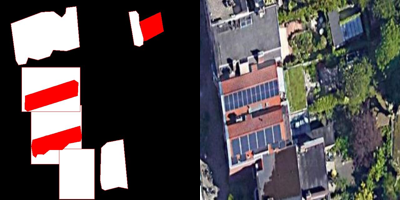

In [85]:
i = 200

dir_ = df_train_dir.iloc[i]["image"]
print(dir_)
dir_mask = df_train_dir.iloc[i]["mask"]
print(dir_mask)

image = Image.open(dir_).resize((200, 200))
image_mask = Image.open(dir_mask).resize((200, 200))

display(Image.fromarray(np.hstack((np.array(image),np.array(image_mask)))))

## valid sest

In [86]:
NAME_ = "valid"
df_valid_dir =  edite_metadata_on_dataframe(NAME_, valid_images, df_valid)

df_valid_dir.head(2)

valid info:
num_valid_image 349
num_masked_valid 171


,image,mask,h,w,c
0,data/roof_panel_seg_v6i_coco_segmentation/valid_mask/valid_0.jpg,data/roof_panel_seg_v6i_coco_segmentation/valid_new/valid_0.jpg,640,640,3
1,data/roof_panel_seg_v6i_coco_segmentation/valid_mask/valid_1.jpg,data/roof_panel_seg_v6i_coco_segmentation/valid_new/valid_1.jpg,640,640,3


In [87]:
df_valid_dir[df_valid_dir["h"]< 640].shape

(0, 5)

data/roof_panel_seg_v6i_coco_segmentation/valid_mask/valid_1.jpg
data/roof_panel_seg_v6i_coco_segmentation/valid_new/valid_1.jpg


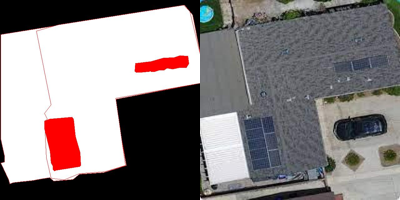

In [89]:
i = 1

dir_ = df_valid_dir.iloc[i]["image"]
print(dir_)
dir_mask = df_valid_dir.iloc[i]["mask"]
print(dir_mask)

image = Image.open(dir_).resize((200, 200))
image_mask = Image.open(dir_mask).resize((200, 200))

display(Image.fromarray(np.hstack((np.array(image),np.array(image_mask)))))

## test set

In [90]:
NAME_ = "test"
df_test_dir =  edite_metadata_on_dataframe(NAME_, test_images, df_test)
df_test_dir.head(2)


test info:
num_test_image 182
num_masked_test 90


,image,mask,h,w,c
0,data/roof_panel_seg_v6i_coco_segmentation/test_mask/test_27.jpg,data/roof_panel_seg_v6i_coco_segmentation/test_new/test_27.jpg,640,640,3
1,data/roof_panel_seg_v6i_coco_segmentation/test_mask/test_45.jpg,data/roof_panel_seg_v6i_coco_segmentation/test_new/test_45.jpg,640,640,3


In [91]:
df_test_dir[df_test_dir["h"]<640].shape

(0, 5)

data/roof_panel_seg_v6i_coco_segmentation/test_mask/test_45.jpg
data/roof_panel_seg_v6i_coco_segmentation/test_new/test_45.jpg


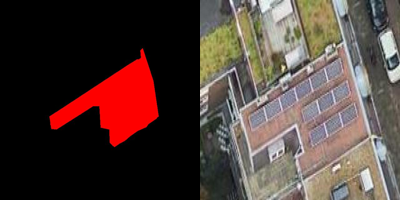

In [92]:
i = 1

dir_ = df_test_dir.iloc[i]["image"]
print(dir_)
dir_mask = df_test_dir.iloc[i]["mask"]
print(dir_mask)

image = Image.open(dir_).resize((200, 200))
image_mask = Image.open(dir_mask).resize((200, 200))

display(Image.fromarray(np.hstack((np.array(image),np.array(image_mask)))))